In [1]:
import pandas as pd
# import pandas_datareader.data as web  # module for reading datasets directly from the web

import numpy as np 

import statsmodels.formula.api as sm # module for stats models
from statsmodels.iolib.summary2 import summary_col # module for presenting stats models outputs nicely

In [2]:
def price2ret(prices,retType='simple'):
    if retType == 'simple':
        ret = (prices/prices.shift(1))-1
    else:
        ret = np.log(prices/prices.shift(1))
    return ret

def assetPriceReg(df_stk, df_factors):
    
    # Reading in factor data
    # df_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench')[0]
    df_factors.rename(columns={'Mkt-RF': 'MKT'}, inplace=True)
    df_factors['MKT'] = df_factors['MKT']/100
    df_factors['SMB'] = df_factors['SMB']/100
    df_factors['HML'] = df_factors['HML']/100
    df_factors['RMW'] = df_factors['RMW']/100
    df_factors['CMA'] = df_factors['CMA']/100
    
    df_stock_factor = pd.merge(df_stk,df_factors,left_index=True,right_index=True) # Merging the stock and factor returns dataframes together
    df_stock_factor['XsRet'] = df_stock_factor['Returns'] - df_stock_factor['RF'] # Calculating excess returns

    # Running CAPM, FF3, and FF5 models.
    CAPM = sm.ols(formula = 'XsRet ~ MKT', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    FF3 = sm.ols( formula = 'XsRet ~ MKT + SMB + HML', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    FF5 = sm.ols( formula = 'XsRet ~ MKT + SMB + HML + RMW + CMA', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})

    CAPMtstat = CAPM.tvalues
    FF3tstat = FF3.tvalues
    FF5tstat = FF5.tvalues

    CAPMcoeff = CAPM.params
    FF3coeff = FF3.params
    FF5coeff = FF5.params

    # DataFrame with coefficients and t-stats
    results_df = pd.DataFrame({'CAPMcoeff':CAPMcoeff,'CAPMtstat':CAPMtstat,
                               'FF3coeff':FF3coeff, 'FF3tstat':FF3tstat,
                               'FF5coeff':FF5coeff, 'FF5tstat':FF5tstat},
    index = ['Intercept', 'MKT', 'SMB', 'HML', 'RMW', 'CMA'])


    dfoutput = summary_col([CAPM,FF3, FF5],stars=True,float_format='%0.4f',
                  model_names=['CAPM','FF3','FF5'],
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'Adjusted R2':lambda x: "{:.4f}".format(x.rsquared_adj)}, 
                             regressor_order = ['Intercept', 'MKT', 'SMB', 'HML', 'RMW', 'CMA'])

    print(dfoutput)
    
    return results_df,dfoutput

In [3]:
# Data source https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
df_factors = pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily_20201003.csv")
df_factors.head()

Unnamed: 0  Mkt-RF   SMB   HML   RMW   CMA     RF
0    19630701   -0.67  0.00 -0.32 -0.01  0.15  0.012
1    19630702    0.79 -0.27  0.27 -0.07 -0.19  0.012
2    19630703    0.63 -0.17 -0.09  0.17 -0.33  0.012
3    19630705    0.40  0.08 -0.28  0.08 -0.33  0.012
4    19630708   -0.63  0.04 -0.18 -0.29  0.13  0.012

In [4]:
df_stk = pd.read_csv("F.csv")
df_stk.head()

Date      Open      High       Low     Close  Adj Close   Volume
0  1972-07-03  2.072119  2.072119  2.051844  2.064009   0.002740   438200
1  1972-07-05  2.064009  2.068064  2.031569  2.051844   0.002724  1395000
2  1972-07-06  2.059954  2.096449  2.059954  2.076174   0.002756  1173500
3  1972-07-07  2.076174  2.088339  2.051844  2.068064   0.002746  1351100
4  1972-07-10  2.068064  2.072119  2.043734  2.043734   0.002713   523700

<AxesSubplot:>

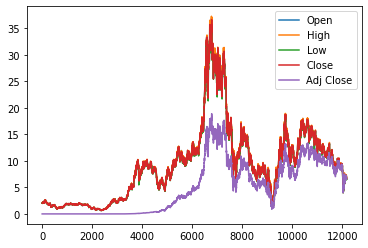

In [5]:
df_stk.drop(['Volume'],axis=1,inplace=True)
df_stk.plot()

In [6]:
df_stk['Returns'] = price2ret(df_stk[['Adj Close']])
df_stk = df_stk.dropna()
df_stk.head()

Date      Open      High       Low     Close  Adj Close   Returns
1  1972-07-05  2.064009  2.068064  2.031569  2.051844   0.002724 -0.005839
2  1972-07-06  2.059954  2.096449  2.059954  2.076174   0.002756  0.011747
3  1972-07-07  2.076174  2.088339  2.051844  2.068064   0.002746 -0.003628
4  1972-07-10  2.068064  2.072119  2.043734  2.043734   0.002713 -0.012017
5  1972-07-11  2.043734  2.059954  2.031569  2.031569   0.002697 -0.005898

<AxesSubplot:>

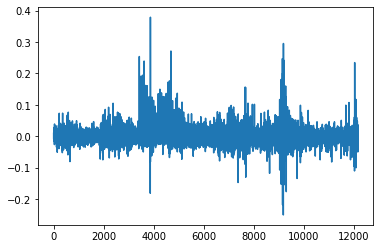

In [7]:
df_stk['Returns'].plot()

<AxesSubplot:>

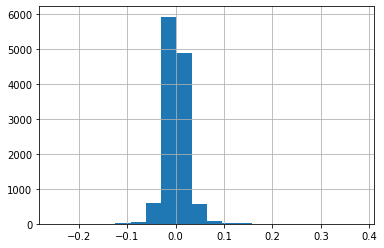

In [8]:
df_stk['Returns'].hist(bins=20)

In [9]:
df_regOutput,df_output = assetPriceReg(df_stk,df_factors)
df_output


                  CAPM       FF3        FF5    
-----------------------------------------------
Intercept      -0.0197*** -0.0197*** -0.0197***
               (0.0003)   (0.0003)   (0.0003)  
MKT            0.0141     0.0216     0.0406    
               (0.0240)   (0.0242)   (0.0261)  
SMB                       0.0557     0.1002*   
                          (0.0540)   (0.0534)  
HML                       0.0253     0.0419    
                          (0.0505)   (0.0605)  
RMW                                  0.1982**  
                                     (0.0808)  
CMA                                  -0.0105   
                                     (0.0847)  
R-squared      0.0000     0.0002     0.0009    
R-squared Adj. -0.0001    -0.0001    0.0005    
N              12169      12169      12169     
Adjusted R2    -0.0001    -0.0001    0.0005    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


<class 'statsmodels.iolib.summary2.Summary'>
"""

===============================================
                  CAPM       FF3        FF5    
-----------------------------------------------
Intercept      -0.0197*** -0.0197*** -0.0197***
               (0.0003)   (0.0003)   (0.0003)  
MKT            0.0141     0.0216     0.0406    
               (0.0240)   (0.0242)   (0.0261)  
SMB                       0.0557     0.1002*   
                          (0.0540)   (0.0534)  
HML                       0.0253     0.0419    
                          (0.0505)   (0.0605)  
RMW                                  0.1982**  
                                     (0.0808)  
CMA                                  -0.0105   
                                     (0.0847)  
R-squared      0.0000     0.0002     0.0009    
R-squared Adj. -0.0001    -0.0001    0.0005    
N              12169      12169      12169     
Adjusted R2    -0.0001    -0.0001    0.0005    
===============================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""